# Keras Functional API

In [1]:
# sudo pip3 install --ignore-installed --upgrade tensorflow
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)
# To ignore keep_dims warning
# tf.logging.set_verbosity(tf.logging.ERROR)


2.13.1
2.13.0


Let’s start with a minimal example that shows side by side a simple Sequential model and its equivalent in the functional API:

In [2]:
from keras.models import Sequential, Model 
from keras import layers 
from keras import Input 

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,))) 
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 3466 (13.54 KB)
Trainable params: 3466 (13.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


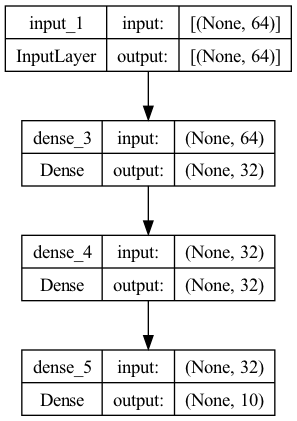

In [3]:
model.summary()

from IPython.display import SVG
from keras.utils import plot_model

# from keras.utils.vis_utils import model_to_dot

plot_model(model,show_shapes=True)#.create(prog='dot', format='svg'))

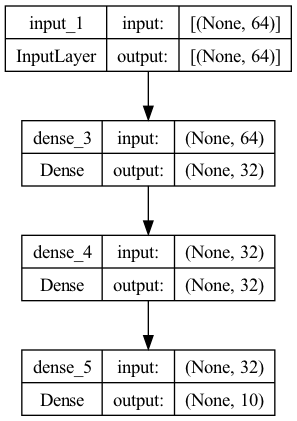

In [4]:
plot_model(model, show_shapes=True)

The only part that may seem a bit magical at this point is instantiating a Model object using only an input tensor and an output tensor. Behind the scenes, Keras retrieves every layer involved in going from input_tensor to output_tensor, bringing them together into a graph-like data structure—a Model. Of course, the reason it works is that output_tensor was obtained by repeatedly transforming input_tensor. 

If you tried to build a model from **inputs and outputs that weren’t related**, you’d get a RuntimeError:

In [5]:
unrelated_input = Input(shape=(32,))
bad_model = Model(unrelated_input, output_tensor)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "dense_3". The following previous layers were accessed without issue: []

This error tells you, in essence, that Keras couldn’t reach input_2 from the provided output tensor. 

When it comes to compiling, training, or evaluating such an instance of Model, the API is *the same as that of Sequential*:

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10)) 

model.fit(x_train, y_train, epochs=10, batch_size=128)

score = model.evaluate(x_train, y_train)

Epoch 1/10
8/8 [==============================] - 0s 866us/step - loss: 11.9872
Epoch 2/10
8/8 [==============================] - 0s 650us/step - loss: 13.6712
Epoch 3/10
8/8 [==============================] - 0s 646us/step - loss: 16.2939
Epoch 4/10
8/8 [==============================] - 0s 607us/step - loss: 19.5296
Epoch 5/10
8/8 [==============================] - 0s 612us/step - loss: 22.9001
Epoch 6/10
8/8 [==============================] - 0s 600us/step - loss: 26.5192
Epoch 7/10
8/8 [==============================] - 0s 569us/step - loss: 30.2837
Epoch 8/10
8/8 [==============================] - 0s 545us/step - loss: 34.0187
Epoch 9/10
8/8 [==============================] - 0s 613us/step - loss: 37.1508
Epoch 10/10
32/32 [==============================] - 0s 336us/step - loss: 42.4366


## Multi-input models


#### A question-answering model example

Following is an example of how you can build such a model with the functional API. You set up two independent branches, encoding the text input and the question input as representation vectors; then, concatenate these vectors; and finally, add a softmax classifier on top of the concatenated representations.

In [7]:
from keras.models import Model
from keras import layers
from keras import Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# The text input is a variable-length sequence of integers. 
# Note that you can optionally name the inputs.
text_input = Input(shape=(None,), dtype='int32', name='text')

# Embeds the inputs into a sequence of vectors of size 64
# embedded_text = layers.Embedding(64, text_vocabulary_size)(text_input)
# embedded_text = layers.Embedding(output_dim=64, input_dim=text_vocabulary_size)(text_input)
embedded_text = layers.Embedding(text_vocabulary_size,64)(text_input)

# Encodes the vectors in a single vector via an LSTM
encoded_text = layers.LSTM(32)(embedded_text)


# Same process (with different layer instances) for the question
question_input = Input(shape=(None,),dtype='int32',name='question')

# embedded_question = layers.Embedding(32, question_vocabulary_size)(question_input)
# embedded_question = layers.Embedding(output_dim=32, input_dim=question_vocabulary_size)(question_input)
embedded_question = layers.Embedding(question_vocabulary_size,32)(question_input)

encoded_question = layers.LSTM(16)(embedded_question) 

# Concatenates the encoded question and encoded text
concatenated = layers.concatenate([encoded_text, encoded_question],axis=-1)

# Adds a softmax classifier on top
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)

# At model instantiation, you specify the two inputs and the output.
model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None, None)]               0         []                            
                                                                                                  
 question (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 64)             640000    ['text[0][0]']                
                                                                                                  
 embedding_1 (Embedding)     (None, None, 32)             320000    ['question[0][0]']            
                                                                                            

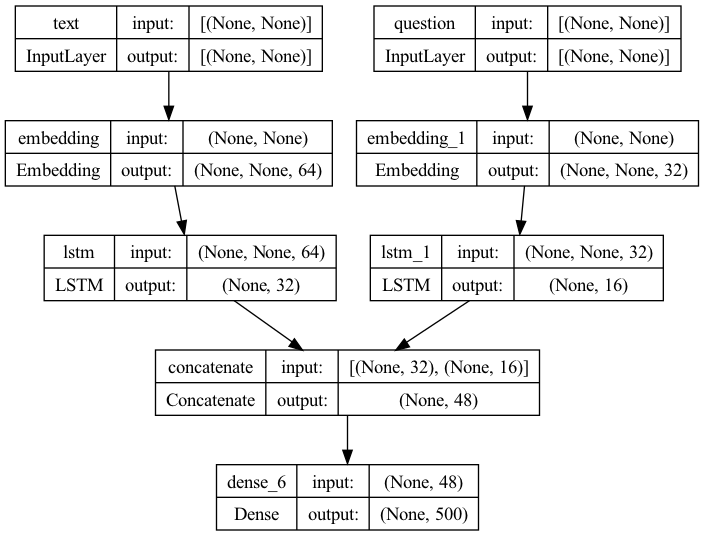

In [9]:
model.summary()

from IPython.display import SVG
# from kera?s.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, show_shapes=True)

Now, how do you **train** this two-input model? 

There are two possible APIs: 
* you can feed the model a list of Numpy arrays as inputs
* you can feed it a dictionary that maps input names to Numpy arrays. 

Naturally, the latter option is available only if you give names to your inputs. 

#### Training the multi-input model

In [10]:
import numpy as np
num_samples = 1000 
max_length = 100

# Generates dummy Numpy data
text = np.random.randint(1, text_vocabulary_size,size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size,size=(num_samples, max_length)) 

# Answers are one-hot encoded, not integers
# answers = np.random.randint(0, 1,size=(num_samples, answer_vocabulary_size))
answers = np.random.randint(answer_vocabulary_size, size=(num_samples))
answers = keras.utils.to_categorical(answers, answer_vocabulary_size)

# Fitting using a list of inputs
print('-'*10,"First training run with list of NumPy arrays",'-'*60)

model.fit([text, question], answers, epochs=10, batch_size=128)

print()

# Fitting using a dictionary of inputs (only if inputs are named)
print('-'*10,"Second training run with dictionary and named inputs",'-'*60)

model.fit({'text': text, 'question': question}, answers,epochs=10, batch_size=128)

---------- First training run with list of NumPy arrays ------------------------------------------------------------
Epoch 1/10
8/8 [==============================] - 1s 33ms/step - loss: 6.2144 - acc: 0.0040
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 6.1895 - acc: 0.0150
Epoch 3/10
8/8 [==============================] - 0s 32ms/step - loss: 6.1127 - acc: 0.0080
Epoch 4/10
8/8 [==============================] - 0s 32ms/step - loss: 6.0437 - acc: 0.0110
Epoch 5/10
8/8 [==============================] - 0s 32ms/step - loss: 5.9879 - acc: 0.0100
Epoch 6/10
8/8 [==============================] - 0s 32ms/step - loss: 5.9355 - acc: 0.0100
Epoch 7/10
8/8 [==============================] - 0s 33ms/step - loss: 5.8628 - acc: 0.0100
Epoch 8/10
8/8 [==============================] - 0s 34ms/step - loss: 5.7937 - acc: 0.0100
Epoch 9/10
8/8 [==============================] - 0s 33ms/step - loss: 5.7151 - acc: 0.0110
Epoch 10/10
8/8 [==============================] - 0s 3

## Multi-output models
You can also use the functional API to build models with multiple outputs (or multiple *heads*). 

####  Example - prediction of Age, Gender and Income from social media posts
A simple example is a network that attempts to simultaneously predict different properties of the data, such as a network that takes as input a series of social media posts from a single anonymous person and tries to predict attributes of that person, such as age, gender, and income level.


In [11]:
from keras import layers
from keras import Input 
from keras.models import Model 

vocabulary_size = 50000 
num_income_groups = 10 

posts_input = Input(shape=(None,), dtype='int32', name='posts')

#embedded_posts = layers.Embedding(256, vocabulary_size)(posts_input) 
embedded_posts = layers.Embedding(vocabulary_size,256)(posts_input)

x = layers.Conv1D(128, 5, activation='relu', padding='same')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x) 
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x) 

# Note that the output layers are given names.

age_prediction = layers.Dense(1, name='age')(x)

income_prediction = layers.Dense(num_income_groups, activation='softmax',name='income')(x)

gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model = Model(posts_input,[age_prediction, income_prediction, gender_prediction])

print("Model is ready!")

Model is ready!


#### Compilation options of a multi-output model: multiple losses

In [12]:
model.compile(optimizer='rmsprop', loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',loss={'age': 'mse',
                                        'income': 'categorical_crossentropy',
                                        'gender': 'binary_crossentropy'})

In [13]:
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10.]) 

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',
              loss={'age': 'mse','income': 'categorical_crossentropy','gender': 'binary_crossentropy'},
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 posts (InputLayer)          [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 256)            1280000   ['posts[0][0]']               
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, None, 128)            163968    ['embedding_2[0][0]']         
                                                                                                  
 max_pooling1d (MaxPooling1  (None, None, 128)            0         ['conv1d[0][0]']        

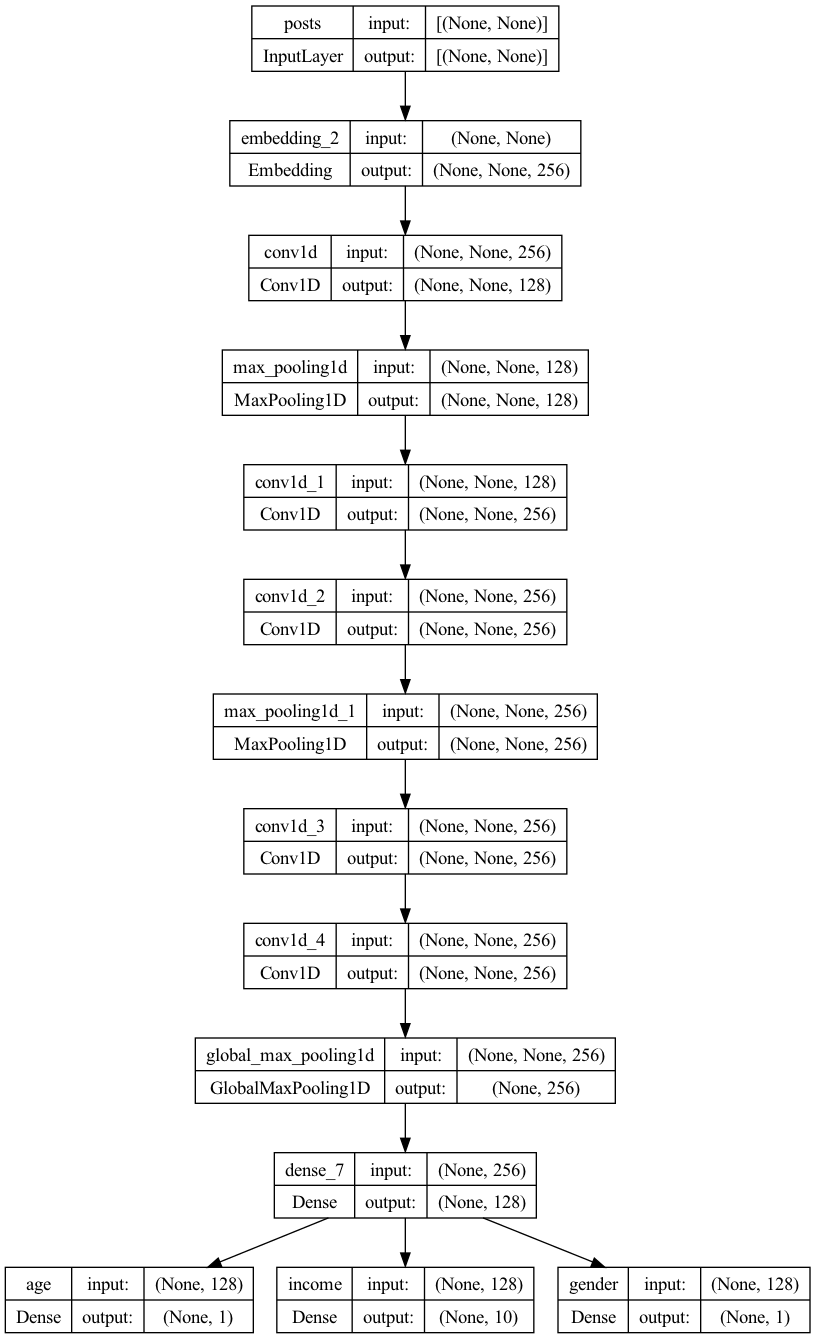

In [15]:
model.summary()

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, show_shapes=True)

#### Feeding data to a multi-output model

Much as in the case of multi-input models, you can pass Numpy data to the model for training either via a list of arrays or via a dictionary of arrays.

#### Training a multi-output model

In [16]:
import numpy as np 

TRACE = False

num_samples = 1000 
max_length = 100 

posts = np.random.randint(1, vocabulary_size, size=(num_samples, max_length))
if TRACE:
    print("*** POSTS ***")
    print(posts.shape)
    print(posts[:10])
    print()

age_targets = np.random.randint(0, 100, size=(num_samples,1))
if TRACE:
    print("*** AGE ***")
    print(age_targets.shape)
    print(age_targets[:10])
    print()

income_targets = np.random.randint(1, num_income_groups, size=(num_samples,1))
income_targets = keras.utils.to_categorical(income_targets,num_income_groups)
if TRACE:
    print("*** INCOME ***")
    print(income_targets.shape)
    print(income_targets[:10])
    print()

gender_targets = np.random.randint(0, 2, size=(num_samples,1))
if TRACE:
    print("*** GENDER ***")
    print(gender_targets.shape)
    print(gender_targets[:10])
    print()

print('-'*10, "First training run with NumPy arrays", '-'*60)

# age_targets, income_targets, and gender_targets are assumed to be Numpy arrays.

model.fit(posts, [age_targets, income_targets, gender_targets], epochs=10, batch_size=64)

print('-'*10,"Second training run with dictionary and named outputs",'-'*60)

# Equivalent (possible only if you give names to the output layers)

model.fit(posts, {'age': age_targets,
                  'income': income_targets,
                  'gender': gender_targets},
          epochs=10, batch_size=64)

---------- First training run with NumPy arrays ------------------------------------------------------------
Epoch 1/10
16/16 [==============================] - 1s 40ms/step - loss: 437.6097 - age_loss: 1678.5457 - income_loss: 4.6506 - gender_loss: 1.3323
Epoch 2/10
16/16 [==============================] - 1s 40ms/step - loss: 238.5659 - age_loss: 893.0662 - income_loss: 2.4604 - gender_loss: 1.2839
Epoch 3/10
16/16 [==============================] - 1s 40ms/step - loss: 179.8517 - age_loss: 664.5401 - income_loss: 2.3530 - gender_loss: 1.1364
Epoch 4/10
16/16 [==============================] - 1s 40ms/step - loss: 106.8985 - age_loss: 362.4435 - income_loss: 2.4054 - gender_loss: 1.3882
Epoch 5/10
16/16 [==============================] - 1s 41ms/step - loss: 101.6327 - age_loss: 354.7687 - income_loss: 2.3585 - gender_loss: 1.0582
Epoch 6/10
16/16 [==============================] - 1s 42ms/step - loss: 97.4997 - age_loss: 338.3994 - income_loss: 2.3667 - gender_loss: 1.0533
Epoch 7/1

### 7.1.4 Directed acyclic graphs of layers 

With the functional API, not only can you build models with multiple inputs and multiple outputs, but you can also implement networks with a complex internal topology. 

Neural networks in Keras are allowed to be arbitrary directed acyclic graphs of layers (the only processing loops that are allowed are those internal to recurrent layers).

Several common neural-network components are implemented as graphs. Two notable ones are <i>Inception modules</i> and <i>residual connections</i>. To better understand how the functional API can be used to build graphs of layers, let’s take a look at how you can implement both of them in Keras.

#### Inception modules 

Inception [3] is a popular type of network architecture for convolutional neural networks. It consists of a stack of modules that themselves look like small independent networks, split into several parallel branches.

##### The purpose of 1 × 1 convolutions 

1 × 1 convolutions (also called pointwise convolutions) are featured in Inception modules, where they contribute to factoring out channel-wise feature learning and space-wise feature learning.
 

In [17]:
from keras import layers 
from keras.layers import Input

# This example assumes the existence of a 4D input tensor x:
# This returns a typical image tensor like those of MNIST dataset 
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Every branch has the same stride value (2), which is necessary to 
# keep all branch outputs the same size so you can concatenate them
branch_a = layers.Conv2D(128, 1, padding='same', activation='relu', strides=2)(x)

# In this branch, the striding occurs in the spatial convolution layer.
branch_b = layers.Conv2D(128, 1, padding='same', activation='relu')(x)
branch_b = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_b)

# In this branch, the striding occurs in the average pooling layer.
branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
branch_c = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)

# Concatenates the branch outputs to obtain the module output
output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

# Adding a classifier on top of the convnet
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

model = keras.models.Model(inputs=x, outputs=predictions)

x.shape: (None, 28, 28, 1)


#### Train the Inception model using the Dataset API and the MNIST data

Inspired by: https://github.com/keras-team/keras/blob/master/examples/mnist_dataset_api.py

In [33]:
import numpy as np
import os
import tempfile

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist

import tensorflow as tf

if K.backend() != 'tensorflow':
    raise RuntimeError('This example can only run with the TensorFlow backend,'
                       ' because it requires the Dataset API, which is not'
                       ' supported on other platforms.')

batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 5
num_classes = 10

def cnn_layers(x):
    
    # This example assumes the existence of a 4D input tensor x:
    # This returns a typical image tensor like those of MNIST dataset 
    print("x.shape:",x.shape)

    # Every branch has the same stride value (2), which is necessary to 
    # keep all branch outputs the same size so you can concatenate them
    branch_a = layers.Conv2D(128, 1, padding='same', activation='relu', strides=2)(x)

    # In this branch, the striding occurs in the spatial convolution layer.
    branch_b = layers.Conv2D(128, 1, padding='same', activation='relu')(x)
    branch_b = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_b)

    # In this branch, the striding occurs in the average pooling layer.
    branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
    branch_c = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_c)

    branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
    branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
    branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)

    # Concatenates the branch outputs to obtain the module output
    output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

    # Adding a classifier on top of the convnet
    output = layers.Flatten()(output)
    output = layers.Dense(512, activation='relu')(output)
    predictions = layers.Dense(num_classes, activation='softmax')(output)
    
    return predictions

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_train = np.expand_dims(x_train, -1)
y_train = tf.one_hot(y_train, num_classes)

# Create the dataset and its associated one-shot iterator.
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()

# Model creation using tensors from the get_next() graph node.
inputs, targets = iterator.get_next()

print("inputs.shape:",inputs.shape)
print("targets.shape:",targets.shape)

model_input = layers.Input(tensor=inputs)
model_output = cnn_layers(model_input)

model = keras.models.Model(inputs=model_input, outputs=model_output)

# model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'],
#               target_tensors=[targets])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


AttributeError: '_BatchDataset' object has no attribute 'make_one_shot_iterator'

In [36]:
import numpy as np
import os
import tempfile

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist

import tensorflow as tf

if K.backend() != 'tensorflow':
    raise RuntimeError('This example can only run with the TensorFlow backend,'
                       ' because it requires the Dataset API, which is not'
                       ' supported on other platforms.')

batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 5
num_classes = 10

def cnn_layers(x):
    
    # This example assumes the existence of a 4D input tensor x:
    # This returns a typical image tensor like those of MNIST dataset 
    print("x.shape:",x.shape)

    # Every branch has the same stride value (2), which is necessary to 
    # keep all branch outputs the same size so you can concatenate them
    branch_a = layers.Conv2D(128, 1, padding='same', activation='relu', strides=2)(x)

    # In this branch, the striding occurs in the spatial convolution layer.
    branch_b = layers.Conv2D(128, 1, padding='same', activation='relu')(x)
    branch_b = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_b)

    # In this branch, the striding occurs in the average pooling layer.
    branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
    branch_c = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_c)

    branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
    branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
    branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)

    # Concatenates the branch outputs to obtain the module output
    output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

    # Adding a classifier on top of the convnet
    output = layers.Flatten()(output)
    output = layers.Dense(512, activation='relu')(output)
    predictions = layers.Dense(num_classes, activation='softmax')(output)
    
    return predictions

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_train = np.expand_dims(x_train, -1)
y_train = tf.one_hot(y_train, num_classes)

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
iterator = iter(dataset)


# Create the dataset and its associated one-shot iterator.
# dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# dataset = dataset.repeat()
# dataset = dataset.shuffle(buffer_size)
# dataset = dataset.batch(batch_size)
# iterator = dataset.make_one_shot_iterator()

# Model creation using tensors from the get_next() graph node.
inputs, targets = iterator.get_next()

print("inputs.shape:",inputs.shape)
print("targets.shape:",targets.shape)

model_input = layers.Input(tensor=inputs)
model_output = cnn_layers(model_input)

model = keras.models.Model(inputs=model_input, outputs=model_output)

# model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'],
#               target_tensors=[targets])

initial_learning_rate = 2e-3
decay_steps = 1000  # Number of steps after which learning rate decays
decay_rate = 0.5    # Decay rate
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)

# Compile your model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

inputs.shape: (128, 28, 28, 1)
targets.shape: (128, 10)
x.shape: (128, 28, 28, 1)


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(128, 28, 28, 1)]           0         []                            
                                                                                                  
 conv2d_60 (Conv2D)          (128, 28, 28, 128)           256       ['input_10[0][0]']            
                                                                                                  
 conv2d_57 (Conv2D)          (128, 28, 28, 128)           256       ['input_10[0][0]']            
                                                                                                  
 average_pooling2d_8 (Avera  (128, 14, 14, 1)             0         ['input_10[0][0]']            
 gePooling2D)                                                                              

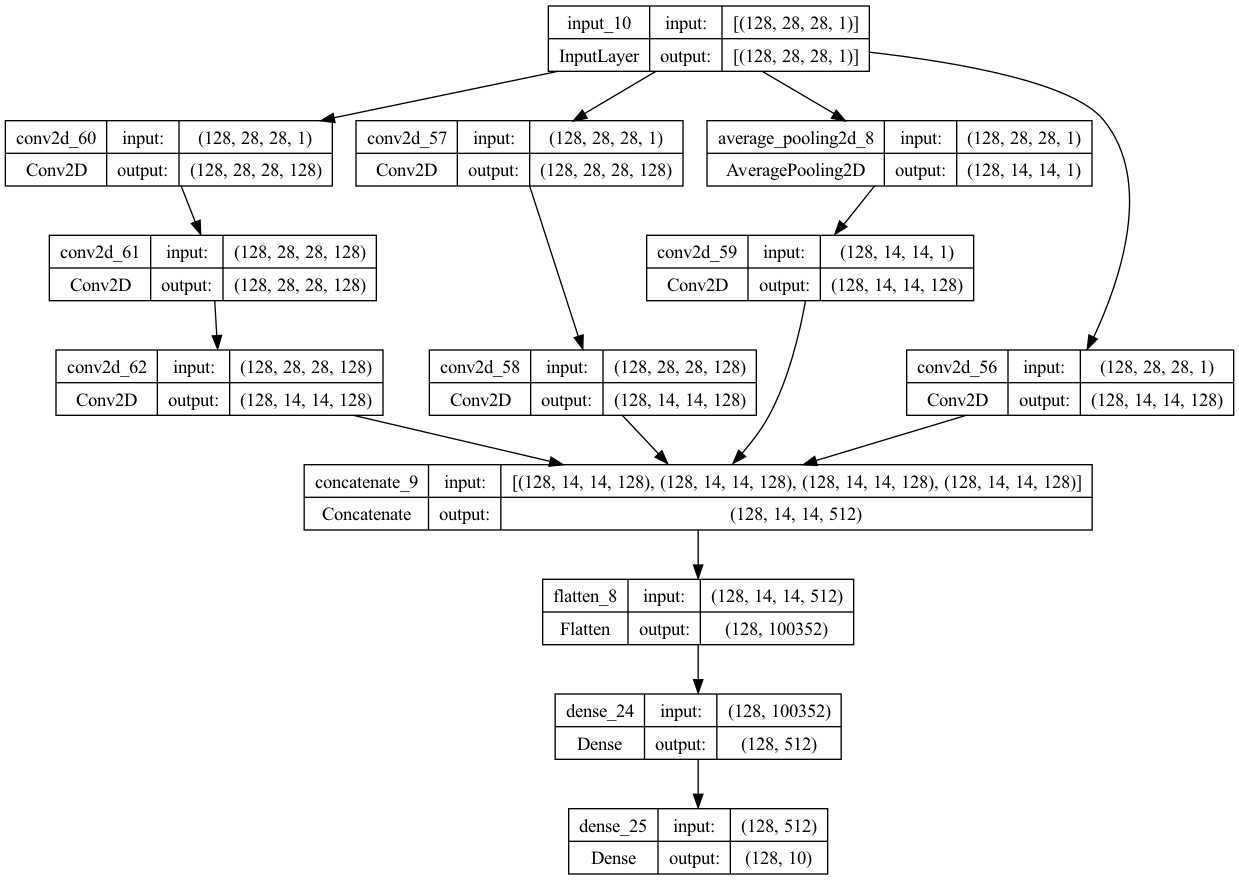

In [38]:
model.summary()

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# model_dot(model,show_shapes=True)#.create(prog='dot', format='svg'))
plot_model(model, show_shapes=True)

#### Train Inception model

In [41]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [40]:
model.fit(iterator, epochs=epochs, steps_per_epoch=steps_per_epoch)


Epoch 1/5
469/469 [==============================] - 224s 476ms/step - loss: 0.1851 - accuracy: 0.9555
Epoch 2/5
469/469 [==============================] - 223s 474ms/step - loss: 0.0325 - accuracy: 0.9901
Epoch 3/5
469/469 [==============================] - 225s 479ms/step - loss: 0.0141 - accuracy: 0.9961
Epoch 4/5
469/469 [==============================] - 226s 481ms/step - loss: 0.0055 - accuracy: 0.9984
Epoch 5/5
469/469 [==============================] - 223s 475ms/step - loss: 0.0031 - accuracy: 0.9994


In [45]:
# model.fit(epochs=epochs,
#           steps_per_epoch=steps_per_epoch)

# Save the model weights.
# weight_path = os.path.join(tempfile.gettempdir(), 'saved_Inception_wt.h5')
weight_path = "./saved_Inception_wt.h5"
model.save_weights(weight_path)

#### Test the Inception model

Second session to test loading trained model without tensors.

In [46]:
# Clean up the TF session.
K.clear_session()

# Second session to test loading trained model without tensors.
x_test = x_test.astype(np.float32)
x_test = np.expand_dims(x_test, -1)

x_test_inp = layers.Input(shape=x_test.shape[1:])
test_out = cnn_layers(x_test_inp)
test_model = keras.models.Model(inputs=x_test_inp, outputs=test_out)

weight_path = os.path.join(tempfile.gettempdir(), 'saved_Inception_wt.h5')
test_model.load_weights(weight_path)

test_model.compile(optimizer='rmsprop',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
test_model.summary()

SVG(model_to_dot(test_model).create(prog='dot', format='svg'))

loss, acc = test_model.evaluate(x_test, y_test, num_classes)
print('\nTest accuracy: {0}'.format(acc))

x.shape: (None, 28, 28, 1, 1)


ValueError: Input 0 of layer "average_pooling2d" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 28, 28, 1, 1)

#### Residual connections - ResNET

Residual connections or ResNET are a common graph-like network component found in many post-2015 network architectures, including Xception. They were introduced by He et al. from Microsoft and are figthing two common problems with large-scale deep-learning model: vanishing gradients and representational bottlenecks. 

A residual connection consists of making the output of an earlier layer available as input to a later layer, effectively creating a shortcut in a sequential network. Rather than being concatenated to the later activation, the earlier output is summed with the later activation, which assumes that both activations are the same size. If they’re different sizes, you can use a linear transformation to reshape the earlier activation into the target shape (for example, a Dense layer without an activation or, for convolutional feature maps, a 1 × 1 convolution without an activation). 

###### ResNET implementation when the feature-map sizes are the same

Here’s how to implement a residual connection in Keras when the feature-map sizes are the same, using identity residual connections. This example assumes the existence of a 4D input tensor x:

In [ ]:
from keras import layers 
from keras.layers import Input

# This example assumes the existence of a 4D input tensor x:
# This returns a typical image tensor like those of MNIST dataset 
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Applies a transformation to x
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

# Adds the original x back to the output features
output = layers.add([y, x])

# Adding a classifier on top of the convnet
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 28, 28, 128)  256         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 128)  256         input_6[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 14, 14, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_27 

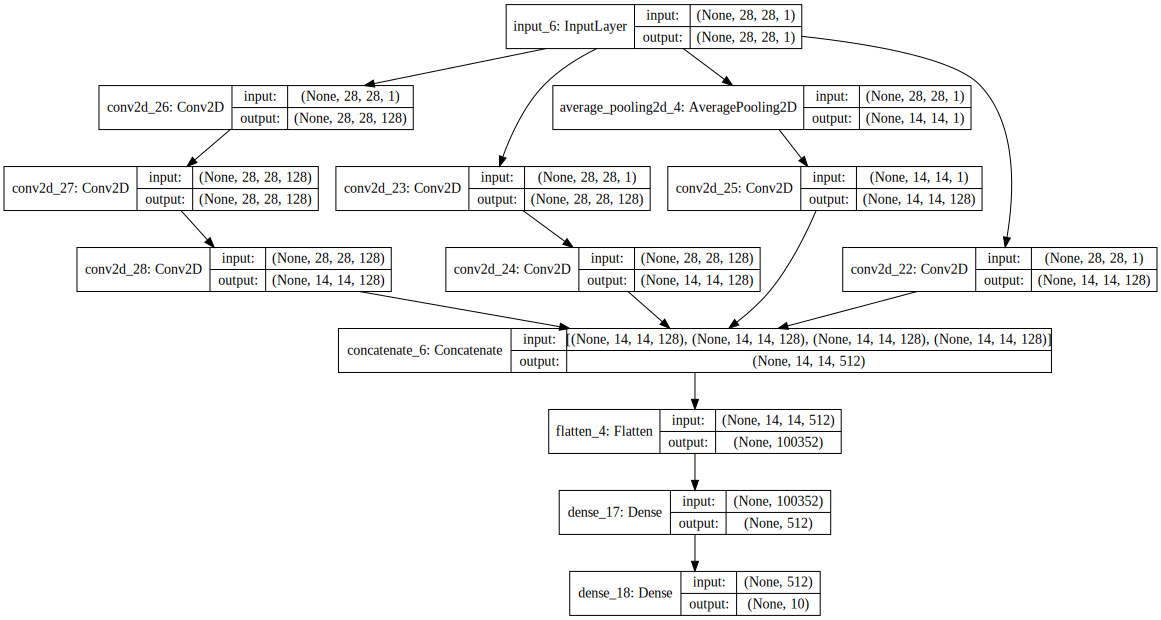

In [ ]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

###### ResNET implementation when the feature-map sizes differ

And the following implements a residual connection when the feature-map sizes differ, using a linear residual connection (again, assuming the existence of a 4D input tensor x):

In [ ]:
from keras import layers 
from keras.layers import Input

# This example assumes the existence of a 4D input tensor x:
# This returns a typical image tensor like those of MNIST dataset 
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Applies a transformation to x
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.MaxPooling2D(2, strides=2)(y)

# Uses a 1 × 1 convolution to linearly downsample the original x tensor to the same shape as y
residual = layers.Conv2D(128, 1, strides=2, padding='same')(x)

# Adds the residual tensor back to the output features
output = layers.add([y, residual])

# Adding a classifier on top of the convnet
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)
model = keras.models.Model(inputs=x, outputs=predictions)

x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 128)  1280        images[0][0]                     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 128)  0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 

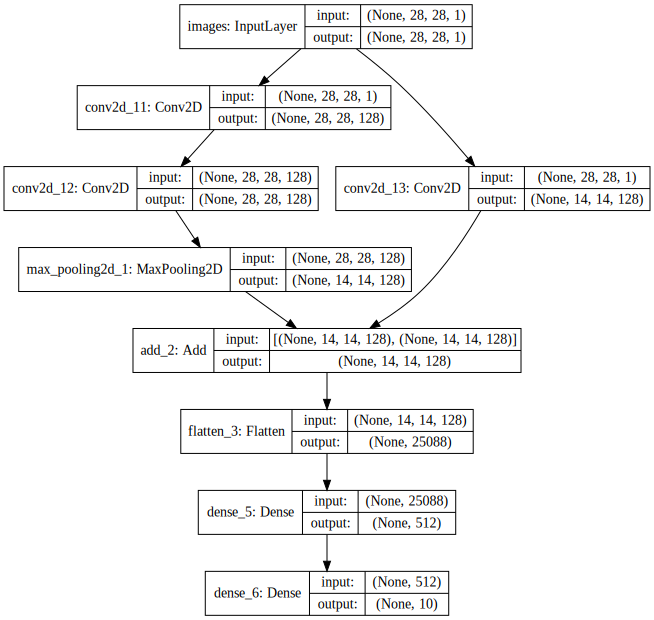

In [ ]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

#### Train the ResNET model using the Dataset API and the MNIST data
(when the feature-map sizes are the same)

In [ ]:
import numpy as np
import os
import tempfile

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist

import tensorflow as tf

if K.backend() != 'tensorflow':
    raise RuntimeError('This example can only run with the TensorFlow backend,'
                       ' because it requires the Dataset API, which is not'
                       ' supported on other platforms.')

batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 5
num_classes = 10

def cnn_layers(x):
    # This example assumes the existence of a 4D input tensor x:
    # This returns a typical image tensor like those of MNIST dataset 
    print("x.shape:",x.shape)
    # Applies a transformation to x
    y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
    y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
    # Adds the original x back to the output features
    output = layers.add([y, x])

    # Adding a classifier on top of the convnet
    output = layers.Flatten()(output)
    output = layers.Dense(512, activation='relu')(output)
    predictions = layers.Dense(10, activation='softmax')(output)
    return predictions

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_train = np.expand_dims(x_train, -1)
y_train = tf.one_hot(y_train, num_classes)

# Create the dataset and its associated one-shot iterator.
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()

# Model creation using tensors from the get_next() graph node.
inputs, targets = iterator.get_next()

print("inputs.shape:",inputs.shape)
print("targets.shape:",targets.shape)

model_input = layers.Input(tensor=inputs)
model_output = cnn_layers(model_input)

model = keras.models.Model(inputs=model_input, outputs=model_output)

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              target_tensors=[targets])

inputs.shape: (?, 28, 28, 1)
targets.shape: (?, 10)
x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 128)  1280        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_15[0][0]                  
__________________________________________________________________________________________________
add_3 (Add

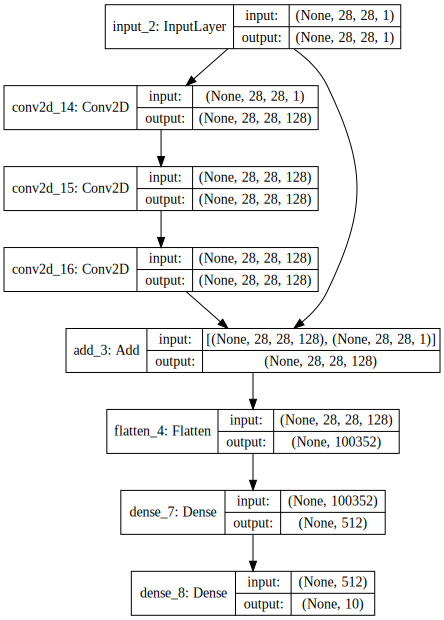

In [ ]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

#### Train and Save the ResNet model

In [ ]:
model.fit(epochs=epochs,
          steps_per_epoch=steps_per_epoch)

# Save the model weights.
weight_path = os.path.join(tempfile.gettempdir(), 'saved_ResNet_wt.h5')
model.save_weights(weight_path)

Epoch 1/5
469/469 [==============================] - 2159s 5s/step - loss: 7.3090 - acc: 0.5429
Epoch 2/5
469/469 [==============================] - 2127s 5s/step - loss: 5.7656 - acc: 0.6412
Epoch 3/5
469/469 [==============================] - 2129s 5s/step - loss: 5.3445 - acc: 0.6674
Epoch 4/5
469/469 [==============================] - 2127s 5s/step - loss: 4.4341 - acc: 0.7239
Epoch 5/5
469/469 [==============================] - 2126s 5s/step - loss: 4.3280 - acc: 0.7306


#### Second session to test loading trained model without tensors.

In [ ]:
# Clean up the TF session.
K.clear_session()

# Second session to test loading trained model without tensors.
x_test = x_test.astype(np.float32)
x_test = np.expand_dims(x_test, -1)

x_test_inp = layers.Input(shape=x_test.shape[1:])
test_out = cnn_layers(x_test_inp)
test_model = keras.models.Model(inputs=x_test_inp, outputs=test_out)

weight_path = os.path.join(tempfile.gettempdir(), 'saved_ResNet_wt.h5')
test_model.load_weights(weight_path)
test_model.compile(optimizer='rmsprop',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
test_model.summary()

loss, acc = test_model.evaluate(x_test, y_test, num_classes)
print('\nTest accuracy: {0}'.format(acc))

x.shape: (?, 28, 28, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_2[0][0]                   
_____________________________________________________________________________________

Not very good... probably normal since residual connection are good with very deep network but here we have only 2 hidden layers.  

### 7.1.5. Layer weights sharing

One more important feature of the functional API is the ability to reuse a layer instance several times where instead of instantiating a new layer for each call, you reuse the same weights with every call. This allows you to build models that have shared branches—several branches that all share the same knowledge and perform the same operations.  

####  Example - semantic similarity between two sentences

For example, consider a model that attempts to assess the semantic similarity between two sentences. The model has two inputs (the two sentences to compare) and outputs a score between 0 and 1, where 0 means unrelated sentences and 1 means sentences that are either identical or reformulations of each other. Such a model could be useful in many applications, including deduplicating natural-language queries in a dialog system. 

In this setup, the two input sentences are interchangeable, because semantic similarity is a symmetrical relationship: the similarity of A to B is identical to the similarity of B to A. For this reason, it wouldn’t make sense to learn two independent models for processing each input sentence. Rather, you want to process both with a single LSTM layer. The representations of this LSTM layer (its weights) are learned based on both inputs simultaneously. This is what we call a Siamese LSTM model or a shared LSTM.

    Note: Siamese network is a special type of neural network architecture. Instead of learning to classify its
    inputs, the Siamese neural network learns to differentiate between two inputs. It learns the similarity.

Here’s how to implement such a model using layer sharing (layer reuse) in the Keras functional API:

In [ ]:
from keras import layers
from keras import Input
from keras.models import Model

# Instantiates a single LSTM layer, once
lstm = layers.LSTM(32)

# Building the left branch of the model: 
# inputs are variable-length sequences of vectors of size 128.
left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

# Building the right branch of the model:
# when you call an existing layer instance, you reuse its weights.
right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

# Builds the classifier on top
merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

# Instantiating the model
model = Model([left_input, right_input], predictions)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, None, 128)    0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 32)           20608       input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 64)           0           lstm_3[0][0]                     
          

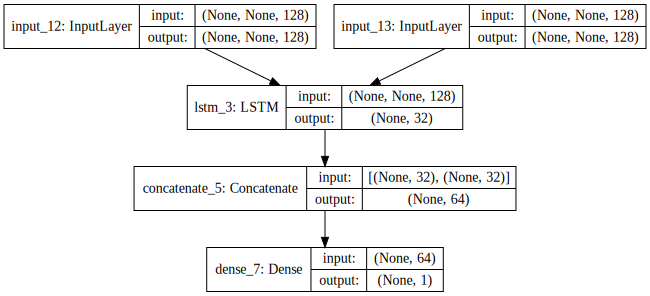

In [ ]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
import numpy as np

num_samples = 100
num_symbols = 2

TRACE = False

left_data = np.random.randint(0,num_symbols, size=(num_samples,1,128))
if TRACE:
    print(type(left_data))
    print(left_data.shape)
    print(left_data)
    print('-'*50)

right_data = np.random.randint(0,num_symbols, size=(num_samples,1,128))
if TRACE:
    print(type(right_data))
    print(right_data.shape)
    print(right_data)
    print('-'*50)

matching_list = [np.random.randint(0,num_symbols) for _ in range(num_samples)]
targets = np.array(matching_list)
if TRACE:
    print(type(targets))
    print(targets.shape)
    print(targets)
    print('-'*50)

# We must compile a model before training/testing.
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

# Training the model: when you train such a model,
# the weights of the LSTM layer are updated based on both inputs.
model.fit([left_data, right_data],targets)

Epoch 1/1
100/100 [==============================] - 4s 37ms/step - loss: 0.7013 - acc: 0.4800


### 7.1.6. Models as layers

Importantly, in the functional API, models can be used as you’d use layers—effectively, you can think of a model as a “bigger layer.” This is true of both the Sequential and Model classes. This means you can call a model on an input tensor and retrieve an output tensor: 

    y = model(x)

If the model has multiple input tensors and multiple output tensors, it should be called with a list of tensors: 

    y1, y2 = model([x1, x2])

When you call a model instance, you’re reusing the weights of the model—exactly like what happens when you call a layer instance. Calling an instance, whether it’s a layer instance or a model instance, will always reuse the existing learned representations of the instance—which is intuitive.

In [ ]:
from keras import layers
from keras import applications 
from keras import Input

nbr_classes = 10

# The base image-processing model is the Xception network (convolutional base only).
xception_base = applications.Xception(weights=None,include_top=False)

# The inputs are 250 × 250 RGB images.
left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

left_features = xception_base(left_input)
# right_input = xception_base(right_input)
right_features = xception_base(right_input)

merged_features = layers.concatenate([left_features, right_features], axis=-1)

predictions = layers.Dense(nbr_classes, activation='softmax')(merged_features)

# Instantiating the model
model = Model([left_input, right_input], predictions)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
xception (Model)                multiple             20861480    input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 8, 8, 4096)   0           xception[1][0]                   
          

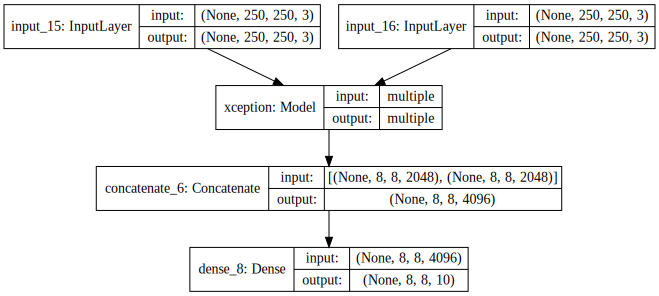

In [ ]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))